In [1]:
import numpy as np

from qiskit import Aer, execute, QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector

from qiskit.aqua.operators import MatrixOp, StateFn

from qiskit.aqua.operators.converters import CircuitSampler
from qiskit.aqua.operators.expectations import PauliExpectation


# define Matrix - and print eigenvalues
M = np.array([[1,  0,  0, 0], 
              [0,  0, -1, 0], 
              [0, -1,  0, 0], 
              [0,  0,  0, 1]])

np.linalg.eig(M)

(array([ 1., -1.,  1.,  1.]),
 array([[ 0.        ,  0.        ,  1.        ,  0.        ],
        [-0.70710678,  0.70710678,  0.        ,  0.        ],
        [ 0.70710678,  0.70710678,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

### Decompose M into  a sum of Pauli matrices
M is a Hermitian Matrix and naturally coresponds to a Hamiltonian operator $ H $. We decompose the operator to a sum of Pauli matrices, $ H = \sum_a w_a P_a $, since we can estimate the expectation value of a Pauli operator through measurements in computational basis and finally estimate the expectation value of H as

$$ \langle H \rangle = \sum_a w_a \langle P_a \rangle $$

In [2]:
H = MatrixOp(M).to_pauli_op()

print(H)

SummedOp([
  0.5 * II,
  -0.5 * XX,
  -0.5 * YY,
  0.5 * ZZ
])


### Ansatz
We choose the following simple variatonal form

In [3]:
# define variatonal form
def ansatz():
    
    phi = Parameter('φ')
    
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.rx(phi, 1)
    qc.cx(0, 1)
    
    return qc, phi


qc, param = ansatz()

print('Variatonal form')
print(qc)

Variatonal form
       ┌───┐       
q_0: ──┤ H ├────■──
     ┌─┴───┴─┐┌─┴─┐
q_1: ┤ RX(φ) ├┤ X ├
     └───────┘└───┘


### Cost function
The cost is simply the expectation value of $ H $.

We measure the expectation value of the Hamiltonian $ H $ using `CircuitSampler` and `PauliExpectation` objects built in Qiskit-Aqua. In short,

- `PauliExpectation` groups the Pauli terms in $ H $ and prepares the circuits for measurements in $ Z, X, Y $ basis. 
- `CircuitSampler` executes the circuits and computes the expectation values.

In [ ]:
BACKEND = Aer.get_backend('qasm_simulator')

sampler = CircuitSampler(BACKEND)
exp = PauliExpectation(group_paulis=True)

qc, param = ansatz()

def cost(phi):
    
    # circuit 
    circ = qc.bind_parameters({param: phi[0]})
    
    # execute and measure expectation value of H
    cost = sampler.convert(exp.convert(~StateFn(H)) @ StateFn(circ)).eval()
    
    return cost.real

Alternatively, we can build our own circuits to estimate the expectation value of the Hamiltonian $ H $. For $ Z \otimes Z $ operator we need measurements in computational $ Z $ basis. Similar, for $ X \otimes X $ and $ Y \otimes Y $ we will use the following identities

$$ \langle \psi(\theta) | X \otimes X |\psi(\theta) \rangle = \langle \psi(\theta) | H^{\otimes 2} \big(Z \otimes Z \big) H^{\otimes 2} |\psi(\theta) \rangle $$

$$ \langle \psi(\theta) | Y \otimes Y |\psi(\theta) \rangle = \langle \psi(\theta) | \big(S H \big)^{\otimes 2} \big(Z \otimes Z \big) \big(H S^{\dagger}\big)^{\otimes 2} |\psi(\theta) \rangle $$

Of course, it holds that

$$ \langle ZZ \rangle = p(00) + p(11) - p(01) - p(10) $$

In [4]:
from qiskit import execute 

BACKEND = Aer.get_backend('qasm_simulator')
qc, param = ansatz()

# ZZ expectation
def ZZ(phi, n_meas=1024):
    
    # circuit 
    circ = qc.bind_parameters({param: phi[0]})
    circ.measure_all()
    
    # simulate 
    result = execute(circ, backend=BACKEND, shots=n_meas).result()
        
    counts = result.get_counts()
    
    expectation = 0.0
    for key in ['00', '11']:
        expectation += counts.get(key, 0.0) / n_meas
        
    for key in ['01', '10']:
        expectation -= counts.get(key, 0.0) / n_meas
        
    return expectation


# XX expectation
def XX(phi, n_meas=1024):
    
    # circuit 
    circ = qc.bind_parameters({param: phi[0]})
    circ.h([0, 1])
    circ.measure_all()
    
    # simulate 
    result = execute(circ, backend=BACKEND, shots=n_meas).result()
        
    counts = result.get_counts()
    
    expectation = 0.0
    for key in ['00', '11']:
        expectation += counts.get(key, 0.0) / n_meas
        
    for key in ['01', '10']:
        expectation -= counts.get(key, 0.0) / n_meas
        
    return expectation


# YY expectation
def YY(phi, n_meas=1024):
    
    # circuit 
    circ = qc.bind_parameters({param: phi[0]})
    circ.sdg([0, 1])
    circ.h([0, 1])
    circ.measure_all()
    
    # simulate 
    result = execute(circ, backend=BACKEND, shots=n_meas).result()
        
    counts = result.get_counts()
    
    expectation = 0.0
    for key in ['00', '11']:
        expectation += counts.get(key, 0.0) / n_meas
        
    for key in ['01', '10']:
        expectation -= counts.get(key, 0.0) / n_meas
        
    return expectation


def cost(phi):
    
    return 0.5 - 0.5 * XX(phi) - 0.5 * YY(phi) + 0.5 * ZZ(phi)

### Optimization

In [5]:
from scipy.optimize import minimize

# random initial choice
phi = np.random.uniform(0, 2 * np.pi)

res = minimize(cost, phi, 
               method='COBYLA')

print('\nLowest eigenvalue: ', res.fun)
res


Lowest eigenvalue:  -1.0


     fun: -1.0
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 14
  status: 1
 success: True
       x: array(3.15812981)

In [6]:
BACKEND = Aer.get_backend('statevector_simulator')

circ = qc.bind_parameters({param: float(res.x)})

result = execute(circ, BACKEND).result()
output_state = result.get_statevector()

print('Eigenvector:\n ', np.around(output_state, decimals=5))

Eigenvector:
  [-0.00585+0.j       0.     -0.70708j  0.     -0.70708j -0.00585+0.j     ]


## VQE in Qiskit-Aqua
For demonstration purposes only, we use the same variatonal form but the VQE instance already built in Qiskit Aqua.

In [8]:
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import SPSA, COBYLA
from qiskit.aqua import QuantumInstance

optimizer = SPSA(maxiter=100)

var_form, _ = ansatz()

vqe = VQE(H, var_form, optimizer)
vqe_result = vqe.run(QuantumInstance(backend=BACKEND))

vqe_result

print('\nLowest eigenvalue: ', vqe_result.eigenvalue)


Lowest eigenvalue:  (-0.9999999972742625+0j)


## Having more fun
In this section, we further explore the structure of the matrix $ M $, give some insight on the chosen variatonal  from in a way that is albeit far from practical, but who cares, we will have a lot of fun!


The first observation is that matrix $ M $ is unitary and naturally corresponds to a quantum circuit. Actually, it's so close to the well known $ SWAP $ operator, only some signs are off. But we can easily fix them with some $ Z $ operators.  

Let's confirm that.

Correct Matrix ? True


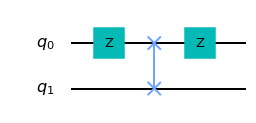

In [9]:
from qiskit.quantum_info import Operator

qc = QuantumCircuit(2)

qc.z(0)
qc.swap(0, 1)
qc.z(0)

print('Correct Matrix ?', np.array_equal(Operator(qc).data, M))

qc.draw('mpl')

After decomposing the $ SWAP $ operator into 3 $ CNOT $ gates

Correct Matrix ? True


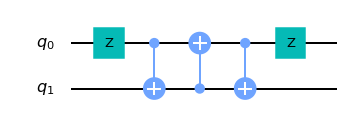

In [10]:
qc = QuantumCircuit(2)

qc.z(0)

# decompose swap
qc.cx(0, 1)
qc.cx(1, 0)
qc.cx(0, 1)

qc.z(0)

print('Correct Matrix ?', np.array_equal(Operator(qc).data, M))

qc.draw('mpl')

we are tempting to choose a variatonal form $ A_{\phi} $ in a way that in $ A_{\phi}^{\dagger} M A_{\phi} $ some $ CNOT $s can be eliminated. 

With this thought, we make the following choice.

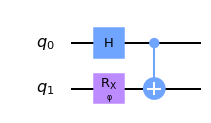

In [11]:
phi = Parameter('φ')
ansatz = QuantumCircuit(2)

ansatz.h(0)
ansatz.rx(phi, 1)
ansatz.cx(0, 1)

ansatz.draw('mpl')

The whole circuit ($ A_{\phi}^{\dagger} M A_{\phi} $) now looks like

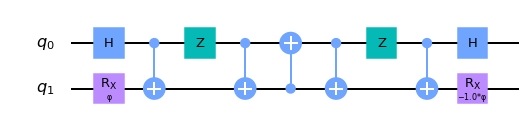

In [12]:
circ = ansatz + qc + ansatz.inverse()

circ.draw('mpl')

Using our transpiler from task 3, we can try to simplify the circuit.

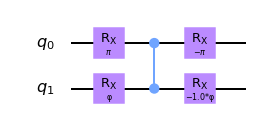

In [13]:
from sys import path
path.append("..")

from task_3.transpiler import RxzCzTranspiler


circ_opt = RxzCzTranspiler(optimize=True).run(circ)
circ_opt.draw('mpl')

With a moment of thought we see that we reduced the initial problem of finding the lowest eigenvalue of $ M $ to optimize the angle of the following variatonal from to minimize the expectation value of a simple $ CZ $ operator.

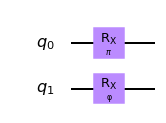

In [14]:
var_form = QuantumCircuit(2)

var_form.rx(np.pi , 0)
var_form.rx(phi, 1)

var_form.draw('mpl')

In [17]:
# compute CZ expectation
BACKEND = Aer.get_backend('qasm_simulator')

def cost(angle, n_meas=1024):
    
    # circuit
    circ = var_form.bind_parameters({phi: angle[0]})
    circ.measure_all()
    
    # simulate 
    result = execute(circ, backend=BACKEND, shots=n_meas).result()     
    counts = result.get_counts()
    
    cz_expectation = 0.0
    for key in ['00', '01', '10']:
        cz_expectation += counts.get(key, 0.0) / n_meas
        
    for key in ['11']:
        cz_expectation -= counts.get(key, 0.0) / n_meas
        
    return cz_expectation

Now we perform the optimization.

In [19]:
from scipy.optimize import minimize

# random initial choice
angle = np.random.uniform(0, 2 * np.pi)

res = minimize(cost, angle, 
               method='COBYLA')

print('\nLowest eigenvalue: ', res.fun)
res


Lowest eigenvalue:  -1.0


     fun: -1.0
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 14
  status: 1
 success: True
       x: array(3.14334792)

And finally we can compute the eigenvector from the chosen variatonal form (ansatz) with the optimized angle.

In [20]:
BACKEND = Aer.get_backend('statevector_simulator')

circ = ansatz.bind_parameters({phi: float(res.x)})
print('Optimized Variatonal form')
print(circ)

result = execute(circ, BACKEND).result()
output_state = result.get_statevector()

print('Eigenvector:\n ', np.around(output_state, decimals=5))

Optimized Variatonal form
         ┌───┐          
q_0: ────┤ H ├───────■──
     ┌───┴───┴────┐┌─┴─┐
q_1: ┤ RX(3.1433) ├┤ X ├
     └────────────┘└───┘
Eigenvector:
  [-0.00062+0.j       0.     -0.70711j  0.     -0.70711j -0.00062+0.j     ]
